In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Load Fake and True News Datasets
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

In [6]:
# Step 3: Label the Datasets
fake_df['label'] = 0  # FAKE
true_df['label'] = 1  # REAL

In [7]:
# Step 4: Merge the Datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

In [8]:
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
df.shape

(44898, 5)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [11]:
# Step 5: Drop Unnecessary Columns
df = df.drop(columns=['subject', 'date'])

In [12]:
# Create Combined Text Feature
df['content'] = df['title'] + " " + df['text']
df.drop(['title', 'text'], axis=1, inplace=True)

In [13]:
# Step 7: Text Preprocessing
stop_words = set(stopwords.words('english'))

In [14]:
df.isnull().sum()

,0
label,0
content,0


In [15]:
df.duplicated().sum()

np.int64(5793)

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [18]:
df['processed'] = df['content'].apply(preprocess)

In [19]:
# Step 8: Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)

In [20]:
X = vectorizer.fit_transform(df['processed']).toarray()
y = df['label']

In [21]:
# Step 9: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression

In [22]:
# Train model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [23]:
# Predictions
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

In [24]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9897711290116353


In [25]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3567
           1       0.99      0.99      0.99      4254

    accuracy                           0.99      7821
   macro avg       0.99      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821



In [26]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Confusion Matrix:
 [[3521   46]
 [  34 4220]]


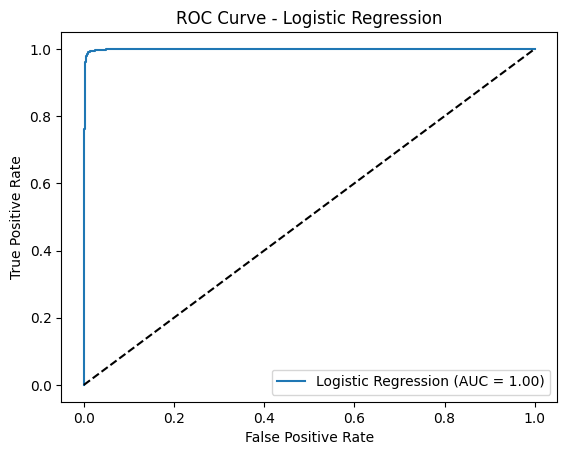

In [27]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [28]:
y_train_pred = lr_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.9903784682265695
